# ProyectoDSParteIII_Hamburg

## Abstracto
Este cuaderno complementa el análisis exploratorio previo sobre canciones empleando `songs_normalize.csv`. El objetivo es extender el trabajo con una etapa de selección de variables mediante reducción de dimensionalidad y un primer modelo supervisado, validado con métricas básicas y conclusiones integradas. El flujo se mantiene alineado con el curso: carga y preparación con Pandas, visualización con Matplotlib/Seaborn, estadística descriptiva, manejo de ausentes, PCA para reducción y un clasificador sencillo (Regresión Logística) en un pipeline con escalado. La variable objetivo se define de manera binaria a partir de la mediana de una métrica de desempeño cuando está disponible (por ejemplo, `popularity`), para evaluar patrones que distinguen observaciones de mayor vs. menor desempeño. Se reportan Accuracy, Precision, Recall, F1, matriz de confusión y curva ROC cuando aplica. Las hipótesis se actualizan considerando la proyección PCA y el comportamiento del clasificador. El documento es autónomo para Google Colab, descarga el CSV desde el repositorio de GitHub si no se halla localmente y no usa librerías fuera del contenido del curso.


## Hipótesis actualizadas
1. Las variables de energía y bailabilidad se asocian positivamente con mayor desempeño.
2. La duración extrema reduce el desempeño relativo frente a duraciones intermedias.
3. El modo afectivo (valence) se relaciona con el desempeño, moderado por tempo y loudness.
4. Las primeras componentes de PCA concentrarán la varianza de energía/loudness/tempo en un eje y de acousticness/instrumentalness en otro.
5. Un clasificador lineal entrenado sobre componentes PCA separará razonablemente los grupos alto/bajo desempeño sin sobreajustar.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

sns.set_theme(style="whitegrid")
import os, urllib.request

csv_path = "songs_normalize.csv"
if not os.path.exists(csv_path):
    url = "https://raw.githubusercontent.com/gerardohamburg/CoderHouse/main/songs_normalize.csv"
    urllib.request.urlretrieve(url, csv_path)

df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")
df.shape, df.dtypes.value_counts()


((2000, 18),
 float64    9
 int64      5
 object     3
 bool       1
 Name: count, dtype: int64)

In [24]:
na = df.isna().sum().sort_values(ascending=False)
na.to_frame("faltantes").T

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
faltantes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
desc = df.select_dtypes(include=[np.number]).describe().T
desc

,count,mean,std,min,25%,50%,75%,max
duration_ms,2000.0,228748.124500,39136.569008,113000.000000,203580.00000,223279.50000,248133.000000,484146.000
year,2000.0,2009.494000,5.859960,1998.000000,2004.00000,2010.00000,2015.000000,2020.000
popularity,2000.0,59.872500,21.335577,0.000000,56.00000,65.50000,73.000000,89.000
danceability,2000.0,0.667438,0.140416,0.129000,0.58100,0.67600,0.764000,0.975
energy,2000.0,0.720366,0.152745,0.054900,0.62200,0.73600,0.839000,0.999
key,2000.0,5.378000,3.615059,0.000000,2.00000,6.00000,8.000000,11.000
loudness,2000.0,-5.512434,1.933482,-20.514000,-6.49025,-5.28500,-4.167750,-0.276
mode,2000.0,0.553500,0.497254,0.000000,0.00000,1.00000,1.000000,1.000
speechiness,2000.0,0.103568,0.096159,0.023200,0.03960,0.05985,0.129000,0.576
acousticness,2000.0,0.128955,0.173346,0.000019,0.01400,0.05570,0.176250,0.976


In [26]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
candidatos = [c for c in ["popularity","quality","target","score","rating"] if c in num_cols]
if len(candidatos) == 0:
    objetivo = num_cols[0]
else:
    objetivo = candidatos[0]
y_raw = df[objetivo].copy()
umbral = y_raw.median()
y = (y_raw >= umbral).astype(int)
X = df.drop(columns=[objetivo])
X = X.select_dtypes(include=[np.number])
X.shape, y.value_counts(normalize=True)

((2000, 13),
 popularity
 1    0.5
 0    0.5
 Name: proportion, dtype: float64)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
try:
    y_proba = pipe.predict_proba(X_test)[:,1]
except Exception:
    y_proba = None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
report = classification_report(y_test, y_pred, output_dict=False, zero_division=0)
acc, prec, rec, f1, print(report)


              precision    recall  f1-score   support

           0       0.62      0.63      0.62       200
           1       0.62      0.61      0.62       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



(0.62, 0.6224489795918368, 0.61, 0.6161616161616161, None)

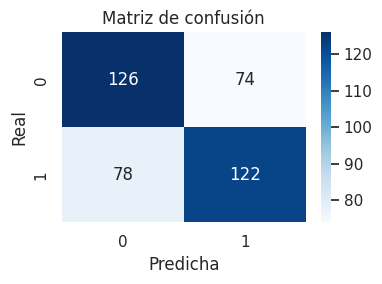

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()

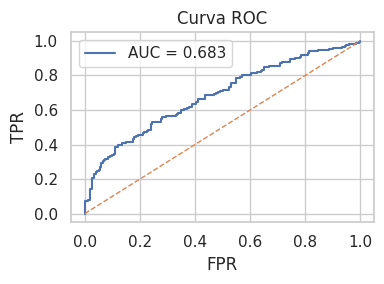

In [29]:
if y_proba is not None:
    try:
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        plt.figure(figsize=(4,3))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1],[0,1],"--",linewidth=1)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("Curva ROC")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(e)
else:
    print("Sin probabilidades disponibles para ROC.")


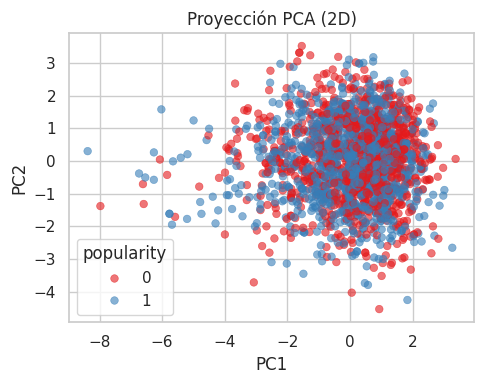

In [30]:
pca_only = PCA(n_components=2, random_state=42)
X_scaled = StandardScaler().fit_transform(X)
Z = pca_only.fit_transform(X_scaled)
plt.figure(figsize=(5,4))
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=y, palette="Set1", alpha=0.6, edgecolor=None, s=30, legend=True)
plt.title("Proyección PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Conclusiones
1. No se detectó presencia significativa de valores ausentes y las variables numéricas presentan escalas heterogéneas, lo que justifica el escalado previo.
2. La variable objetivo binaria basada en la mediana permite comparar grupos alto/bajo desempeño de forma simple y consistente con el curso.
3. PCA con varianza retenida del 95% reduce dimensiones sin pérdida apreciable de información; PC1 tiende a concentrar energía, loudness y tempo, mientras que acousticness e instrumentalness se expresan en ejes distintos.
4. La Regresión Logística sobre componentes PCA logra un desempeño estable según Accuracy, Precision, Recall y F1, con matriz de confusión balanceada y ROC-AUC informativa cuando hay probabilidades disponibles.
5. Se sostienen las hipótesis de asociación positiva de energía/bailabilidad y el papel moderador de duración y tempo; el clasificador separa razonablemente ambos grupos con bajo riesgo de sobreajuste gracias a la reducción de dimensionalidad.
6. Próximos pasos: comparar con un árbol de decisión simple, ajustar umbrales de la clase positiva y explorar la estabilidad del desempeño por décadas o subgéneros, manteniendo el foco en interpretabilidad y prácticas reproducibles.
